In [16]:
!pip install torchinfo

## References
- https://ijdykeman.github.io/ml/2016/12/21/cvae.html

In [91]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


from torchinfo import summary

torch.__version__

'1.9.0+cu102'

In [4]:
from load_mnist import train_test_loader

In [3]:
available_device= "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(available_device)
print(device)

cpu


## Loading the MNIST Dataloader

In [6]:
BATCH_SIZE = 64

train_loader, test_loader = train_test_loader(BATCH_SIZE, device)

print("Data loaded")

Data loaded


In [86]:
for x, y in train_loader:
  print(x.shape)
  print(x.dtype)
  print(y.shape)
  print(y)
  break

torch.Size([64, 1, 28, 28])
torch.float32
torch.Size([64])
tensor([0, 9, 2, 9, 1, 3, 9, 1, 3, 4, 8, 6, 6, 5, 2, 3, 5, 8, 7, 1, 4, 4, 9, 0,
        4, 3, 8, 6, 2, 2, 0, 4, 8, 9, 9, 3, 2, 0, 5, 6, 4, 6, 3, 9, 5, 4, 4, 6,
        6, 7, 4, 3, 3, 1, 8, 2, 5, 8, 1, 1, 0, 0, 8, 1])


In [90]:

y_one_hot = F.one_hot(y).float()
print(y_one_hot.dtype)
y_one_hot.shape


torch.float32


torch.Size([64, 10])

In [10]:
def show_grid_tensor(grid_im, n, c=None):
    fig = plt.figure(figsize=(15,15))
    for i in range(n):
        ax = plt.subplot(8, 8, i+1)
        plt.imshow(grid_im[i], cmap=c)
        plt.axis("off")
        # ax.set_title(f"activation {i}")
    return plt

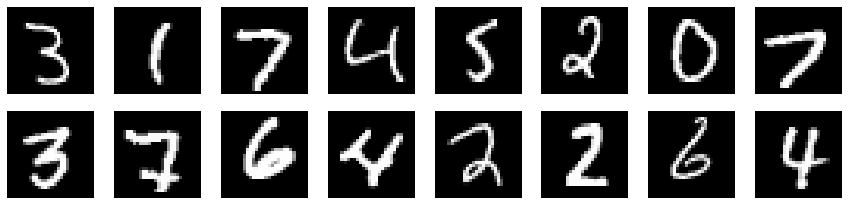

In [11]:
# x shape = [N, channels, H, W]
# view_batch shape = [N, H, W, channels]
view_batch = x.permute(0, 2, 3, 1)
ax1 = show_grid_tensor(view_batch.squeeze(), 16, c='gray')
ax1.show()



In [64]:
x1 = torch.randn(10,40)
x2 = torch.randn(10,12)
x3 = torch.cat([x1,x2], axis=1)
x3.shape

torch.Size([10, 52])

## Encoder

In [93]:
class Encoder(nn.Module):
    def __init__(self, input_size=784, label_size=10, latent_size=10):
        """
        """
        super(Encoder, self).__init__()
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
                        nn.Linear(input_size+label_size, 256),
                        nn.LeakyReLU(0.01),
                        nn.Linear(256, 128),
                        nn.LeakyReLU(0.01)
                    )

        self.z_mu = nn.Linear(128, self.latent_size)
        self.z_log_var = nn.Linear(128, self.latent_size)
    
    def reparameterize(self, z_mu, z_log_var):
        """
        z = mu + x * var
        """
        batch_size = z_mu.shape[0]
        x = torch.randn(batch_size, self.latent_size).to(z_mu.device)
        z = z_mu + x * torch.exp(z_log_var/2.)
        return z
    
    def forward(self, x, y):
        """
        """
        x = self.encoder(torch.cat([x,y], axis=1))
        z_mu = self.z_mu(x)
        z_logvar = self.z_log_var(x)

        return z_mu, z_logvar


In [94]:
e = Encoder(input_size=784, label_size=10, latent_size=10)
summary(e, ((64,784),(64,10)))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  --                        --
├─Sequential: 1-1                        [64, 128]                 --
│    └─Linear: 2-1                       [64, 256]                 203,520
│    └─LeakyReLU: 2-2                    [64, 256]                 --
│    └─Linear: 2-3                       [64, 128]                 32,896
│    └─LeakyReLU: 2-4                    [64, 128]                 --
├─Linear: 1-2                            [64, 10]                  1,290
├─Linear: 1-3                            [64, 10]                  1,290
Total params: 238,996
Trainable params: 238,996
Non-trainable params: 0
Total mult-adds (M): 15.30
Input size (MB): 0.20
Forward/backward pass size (MB): 0.21
Params size (MB): 0.96
Estimated Total Size (MB): 1.37

## Decoder

In [95]:
class Decoder(nn.Module):
    def __init__(self, output_size=784, label_size=10, latent_size=10):
        """
        """
        super(Decoder, self).__init__()

        self.latent_size = latent_size
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_size+label_size, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, encodings, y):
        """
        """
        conditioned_encodings  = torch.cat([encodings, y], axis=1)
        decoded_x = self.decoder(conditioned_encodings)
        return decoded_x

In [96]:
d = Decoder(output_size=784, label_size=10, latent_size=10)
summary(d, ((64,10),(64,10)))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  --                        --
├─Sequential: 1-1                        [64, 784]                 --
│    └─Linear: 2-1                       [64, 128]                 2,688
│    └─LeakyReLU: 2-2                    [64, 128]                 --
│    └─Linear: 2-3                       [64, 256]                 33,024
│    └─LeakyReLU: 2-4                    [64, 256]                 --
│    └─Linear: 2-5                       [64, 784]                 201,488
│    └─Sigmoid: 2-6                      [64, 784]                 --
Total params: 237,200
Trainable params: 237,200
Non-trainable params: 0
Total mult-adds (M): 15.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.60
Params size (MB): 0.95
Estimated Total Size (MB): 1.55

## Initialize the model

In [114]:
latent_dim = 10
encoder = Encoder(input_size=784, latent_size=latent_dim).to(device)
decoder = Decoder(output_size=784, latent_size=latent_dim).to(device)

## Loss functions

In [115]:
reconstruction_loss = nn.L1Loss()

def kl_divergence(z_mu, z_log_var):
    """

    """
    kl_div = -0.5 * torch.sum(1 + z_log_var - z_mu**2 - torch.exp(z_log_var), 
                              axis=1) # sum over latent dimension
    return kl_div.mean()



## Optimizer

In [116]:
from itertools import chain

In [117]:
lr = 0.0002
optimizer = optim.Adam(chain(encoder.parameters(),decoder.parameters()),
                               lr=lr)

# Training

In [118]:
from tqdm.notebook import tqdm

In [119]:
NUM_EPOCHS = 10

In [120]:
# x.device

device(type='cpu')

In [112]:
torch.eye(10,10)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

  0%|          | 0/938 [00:00<?, ?it/s]

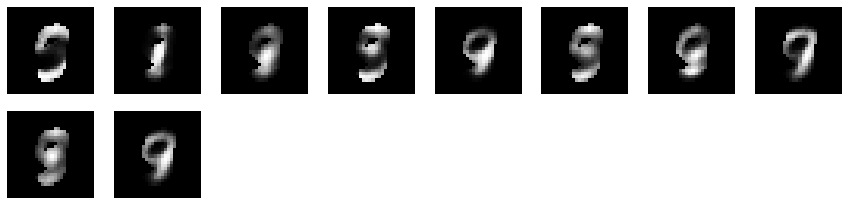

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

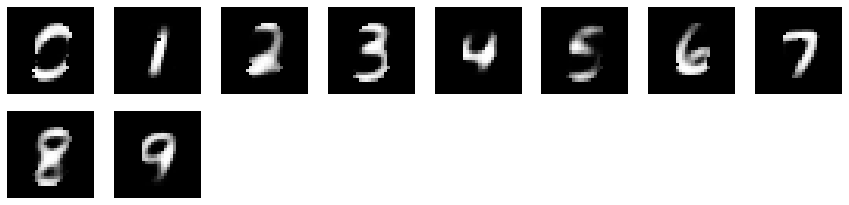

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Done training


In [122]:
fixed_noise_batch = 10
fixed_noise  = torch.rand(fixed_noise_batch, latent_dim).to(device)
num_classes = 10
y_noise_label = torch.eye(fixed_noise_batch, num_classes).to(device).float()

for epoch in range(NUM_EPOCHS):

    # model.train()
    loop = tqdm(train_loader,
            total=len(train_loader),
            leave=True)
    
    # encoder.train()
    decoder.train()

    for x, y in loop:
        x = x.reshape(-1, 28*28).to(device)
        y = y.to(device)
        y_one_hot = F.one_hot(y,num_classes=num_classes).float()

        optimizer.zero_grad()
        # print(y_one_hot.shape)
        z_mu, z_log_var = encoder(x, y_one_hot)
         
        encoded = encoder.reparameterize(z_mu, z_log_var)

        decoded_x  = decoder(encoded, y_one_hot)

        rl = reconstruction_loss(x, 
                                decoded_x)
        
        kl_d = kl_divergence(z_mu, z_log_var)

        loss = rl + kl_d
        loss.backward()

        optimizer.step()
        
        loop.set_description(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss.item(), 
                         rl_loss=rl.item(), 
                         kl_div=kl_d.item())
        # break
    """
    Checking on the fixed noise for each epoch
    """
    # break
    if epoch%5==0 or epoch==9:
        decoder.eval()
        with torch.no_grad():  
          # generating the images
            x_random = decoder(fixed_noise, y_noise_label).detach()

        gen_x = x_random.reshape(fixed_noise_batch, 28, 28)
        # print(gen_x.shape)
        ax1 = show_grid_tensor(gen_x.cpu(), fixed_noise_batch, c='gray')
        ax1.show()

print("Done training")

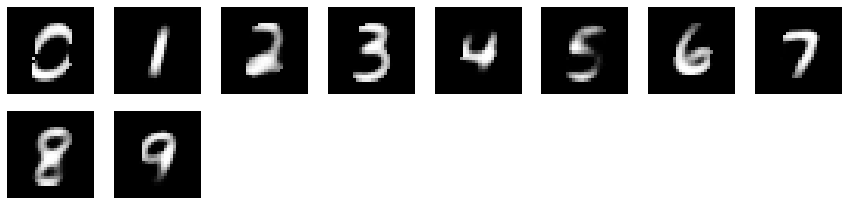

In [123]:
decoder.eval()
with torch.no_grad():  
    # generating the images
    x_random = decoder(fixed_noise, y_noise_label).detach()

gen_x = x_random.reshape(fixed_noise_batch, 28, 28)
# print(gen_x.shape)
ax1 = show_grid_tensor(gen_x.cpu(), fixed_noise_batch, c='gray')
ax1.show()